<a href="https://colab.research.google.com/github/uptrain-ai/uptrain/blob/main/examples/checks/custom/custom_evals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="uptrain">
  </a>
</h1>

<h1 style="text-align: center;">Building Custom Evaluations using UpTrain</h1>

UpTrain offers a multitude of [pre-built evaluations](https://docs.uptrain.ai/predefined-evaluations/overview) that use custom prompt templates to evaluate your model's performance.
These checks include multiple use cases covering (respose quality, tonality, context awareness, code related evaluations and a lot more...)

You can also create your own custom prompt templates for evaluations, you can check out the [Custom Prompt Evals Tutorial](https://github.com/uptrain-ai/uptrain/blob/main/examples/checks/custom/custom_prompt_evals.ipynb). 

All of these evaluations involve making LLM calls. This is not always necessary. Some evaluations can be done with simple Python code, for example: 
- Check for the total number of distinct words
- Check for the average number of unique words
- Check for the presence of "numbers"

You can of course make an LLM call for that, but why to spend money when you can directly code the checks for that.

In this tutorial, we will show you how to create such custom evaluations using Python code.

## Step 1: Install UpTrain by running 'pip install uptrain'

In [1]:
#!pip install uptrain

## Step 2: Let's define the custom evaluation

We will use UpTrain to check for these custom evaluations over the following cases:
- Check for the average number of unique words
- Check for average length of words

First, let's import the required dependencies

In [2]:
from uptrain.framework.base import Settings
from uptrain.operators.base import TransformOp, register_custom_op, TYPE_TABLE_OUTPUT
import polars as pl

**Example 1:** Check for the average number of unique words

> **Note:** Please ensure to add the prefix "score_" to the value in `col_out_score` if you wish to log these results on uptrain's locally hosted dashboard

In [3]:
@register_custom_op
class DiverseVocabularyEval(TransformOp):
    
    col_in_text: str = "response"
    col_out_score: str = "score_diverse_vocabulary"

    def setup(self, settings: Settings):
        return self

    def run(self, data: pl.DataFrame) -> TYPE_TABLE_OUTPUT:
        scores = data.get_column(self.col_in_text).map_elements(lambda s : round(len(set(s.split())) / len(s.split()), 2))
        return {"output": data.with_columns([scores.alias(self.col_out_score)])}

**Example 2** Check for average length of words

In [4]:
@register_custom_op
class AverageWordLengthEval(TransformOp):
    col_in_text: str = "response"
    col_out_score: str = "score_average_word_length"

    def setup(self, settings: Settings):
        return self

    def run(self, data: pl.DataFrame) -> TYPE_TABLE_OUTPUT:
        scores = data.get_column(self.col_in_text).map_elements(lambda s : round(sum(map(lambda word: len(word), s.split())) / len(s.split()), 2))
        return {"output": data.with_columns([scores.alias(self.col_out_score)])}

### Step 3: Run the evaluations of UpTrain's Open-Source Software (OSS)

Let's define a dataset

In [5]:
data = [
    {
        "question": "What are the primary components of a cell?",
        "response": "A cell comprises a cell membrane, cytoplasm, and nucleus. The cell membrane regulates substance passage, the cytoplasm contains organelles, and the nucleus houses genetic material."
    },
    {
        "question": "How does photosynthesis work?",
        "response": "Photosynthesis converts light energy into chemical energy in plants, algae, and some bacteria. Chlorophyll absorbs sunlight, synthesizing glucose from carbon dioxide and water, with oxygen released as a byproduct."
    },
    {
        "question": "What are the key features of the Python programming language?",
        "response": "Python is a high-level, interpreted language known for readability. It supports object-oriented, imperative, and functional programming with a large standard library, dynamic typing, and automatic memory management."
    }
]

First, let's import the required dependencies

In [6]:
from uptrain import EvalLLM, Settings
import os

/Users/shreyanshjain/Documents/UpTrain/GitHub_Clone/uptrain/.venv/lib/python3.11/site-packages/lazy_loader/__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)


All done! Now let's run these evaluations

In [7]:
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

eval_llm = EvalLLM(openai_api_key=OPENAI_API_KEY)

results = eval_llm.evaluate(
    project_name = 'UpTrain Demo',
    data=data,
    checks=[
        DiverseVocabularyEval(col_in_text="response"),
        AverageWordLengthEval(col_in_text="response"), 
    ],
)

> **Note:** By default UpTrain runs locally on your system. You can also ensure this by passing `Settings(evaluate_locally=True)` to EvalLLM

In [8]:
results

[{'question': 'What are the primary components of a cell?',
  'response': 'A cell comprises a cell membrane, cytoplasm, and nucleus. The cell membrane regulates substance passage, the cytoplasm contains organelles, and the nucleus houses genetic material.',
  'score_diverse_vocabulary': 0.84,
  'score_average_word_length': 6.24},
 {'question': 'How does photosynthesis work?',
  'response': 'Photosynthesis converts light energy into chemical energy in plants, algae, and some bacteria. Chlorophyll absorbs sunlight, synthesizing glucose from carbon dioxide and water, with oxygen released as a byproduct.',
  'score_diverse_vocabulary': 0.93,
  'score_average_word_length': 6.38},
 {'question': 'What are the key features of the Python programming language?',
  'response': 'Python is a high-level, interpreted language known for readability. It supports object-oriented, imperative, and functional programming with a large standard library, dynamic typing, and automatic memory management.',
  's

### Step 4: Visualize these results

Now that you have generated these evaluations, you can also visualize the results on UpTrain's Dashboard.

This Dashboard is a part of UpTrain's open-source offering and runs locally on your device. 

Check out this [documentation](https://docs.uptrain.ai/dashboard/getting_started) to get started with UpTrain Dashboard

![Screenshot 2024-03-20 at 6.36.21 PM.png](<attachment:Screenshot 2024-03-20 at 6.36.21 PM.png>)
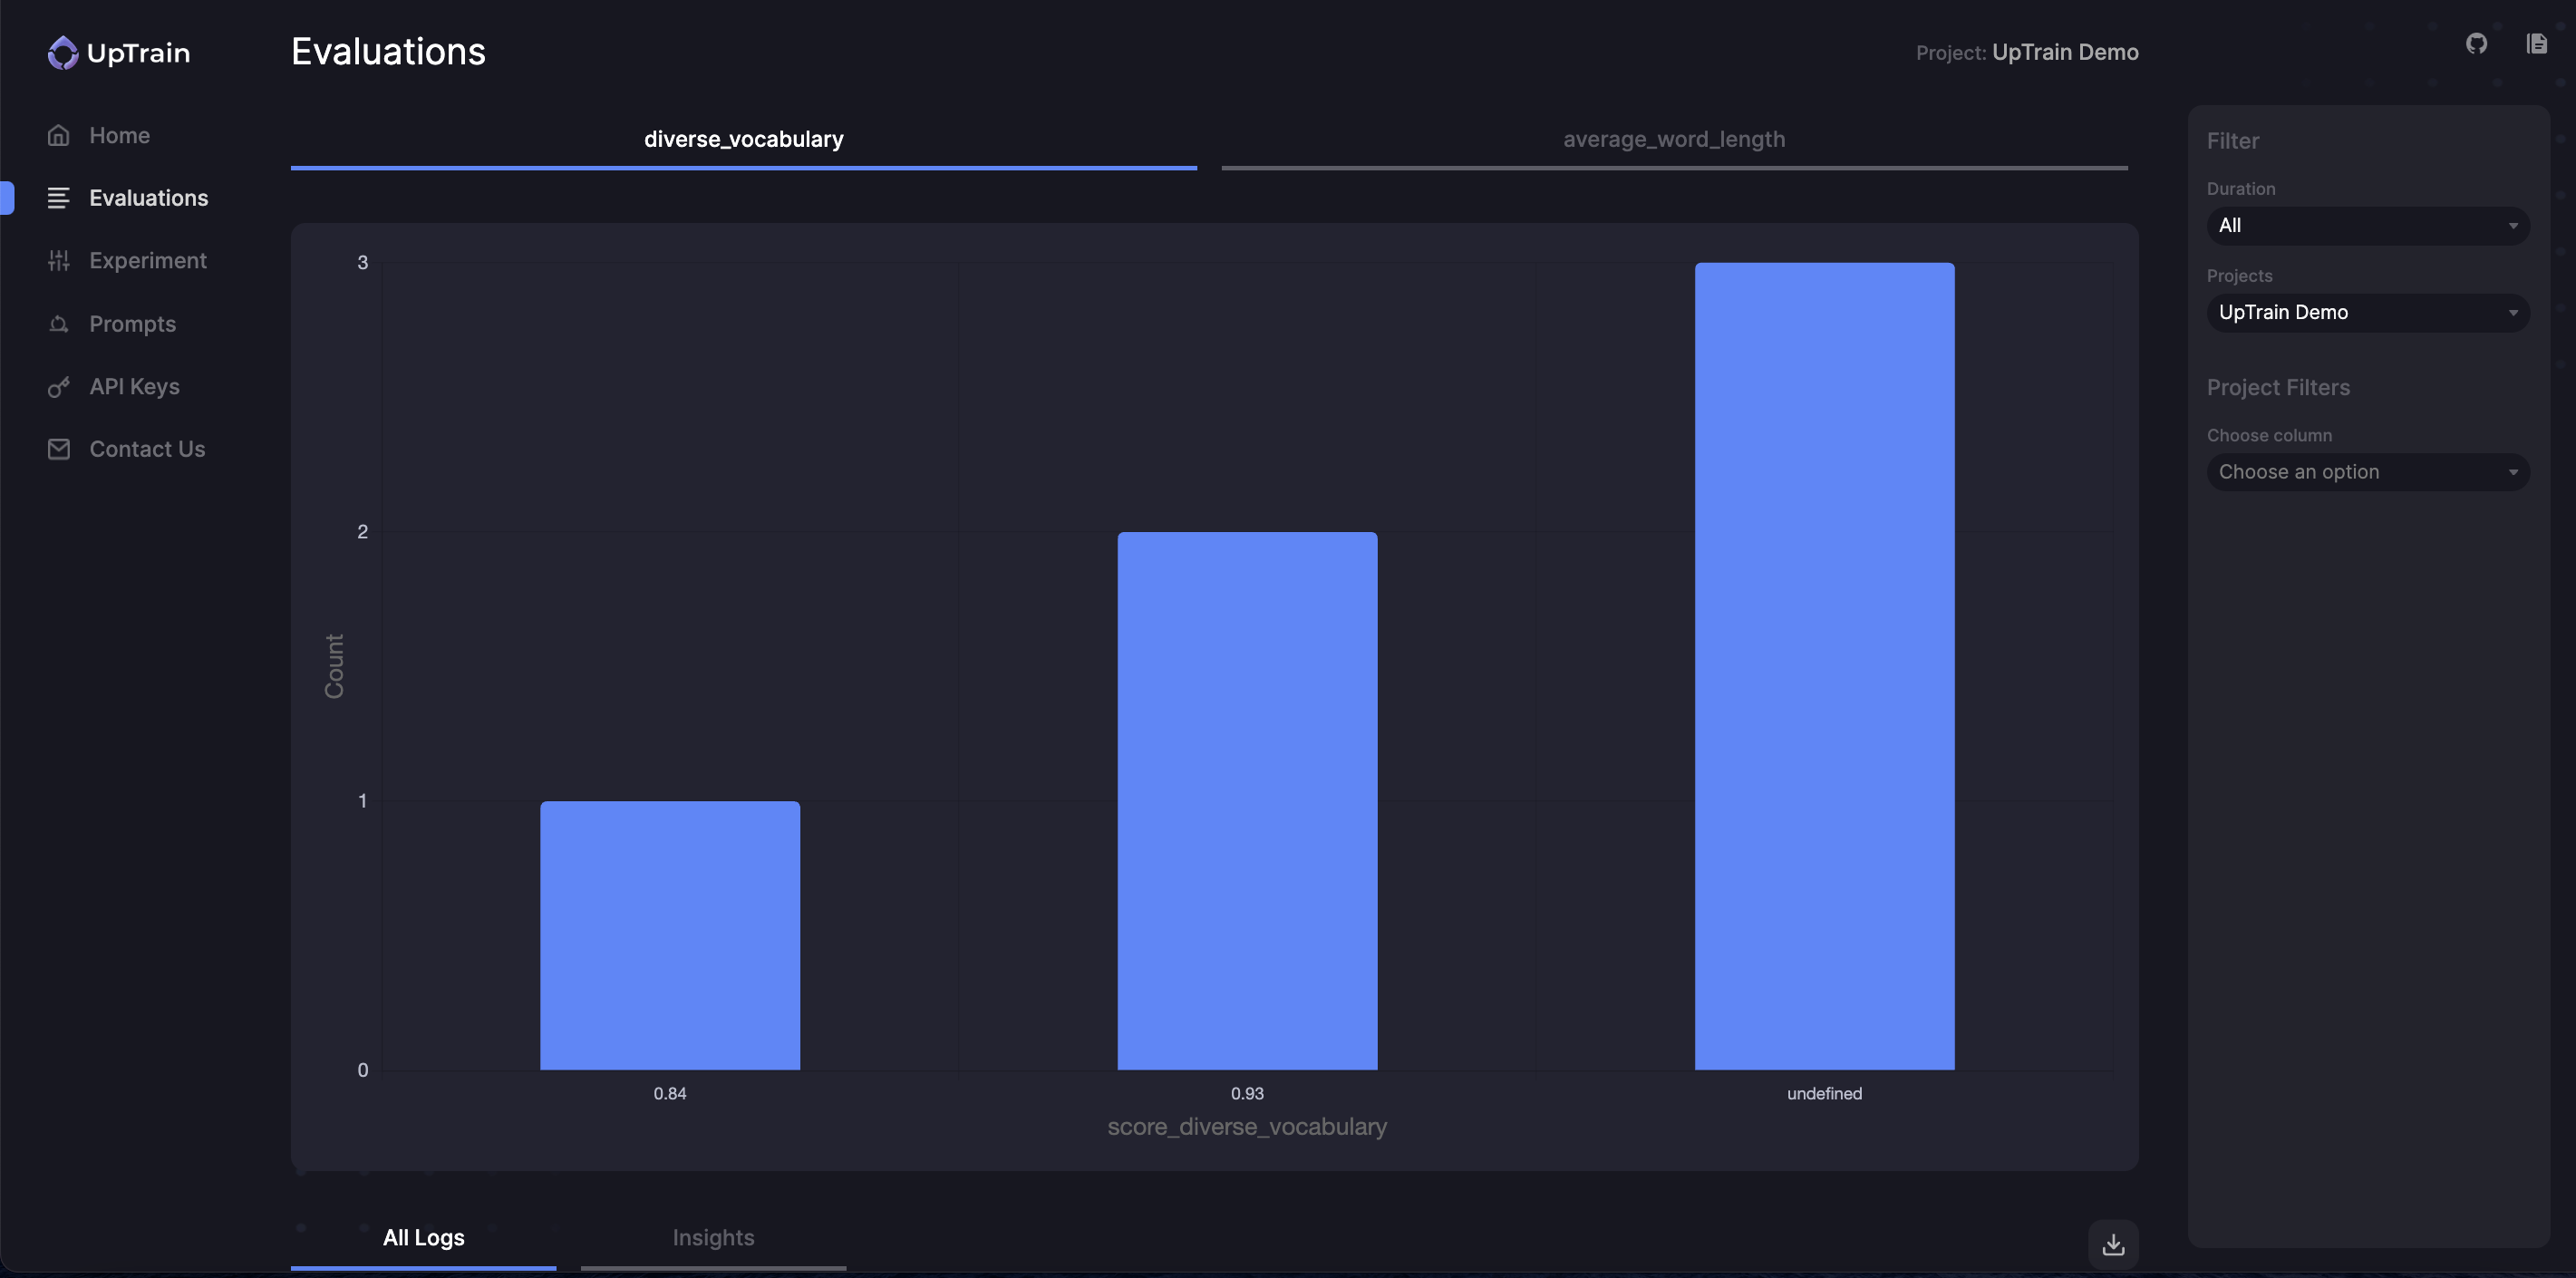

### Bonus

We have already defined some prebuilt evaluations that you can use without the hassle of writing the code for them

|Operator|Description|Input|Output|
|--|--|--|--|
|`DocsLinkVersion()`| Extracts version numbers from URLs in response|`response`|`docs_link_version`|
|`WordCount()`| Calculate the number of words in response|`response`|`word_count`|
|`TextLength()`| Calculate the length of text in response|`response`|`text_length`|
|`KeywordDetector()`| Detects the presence of a keyword in response|`response`, `keyword`|`keyword_detector`|

In [9]:
from uptrain.operators.language.text import WordCount
from uptrain.operators.language.text import KeywordDetector
from uptrain import EvalLLM

OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")


eval_llm = EvalLLM(openai_api_key=OPENAI_API_KEY)

results = eval_llm.evaluate(
    project_name = 'UpTrain Demo',
    data=data,
    checks=[
        WordCount(col_in_text = "response"),
        KeywordDetector(col_in_text = "response", keyword = 'Python'), 
    ],
)

2024-03-20 18:46:03.337 | DEBUG    | uptrain.framework.base:run:217 - Executing node: operator_0 for operator DAG: dummy
2024-03-20 18:46:03.339 | DEBUG    | uptrain.framework.base:run:217 - Executing node: operator_0 for operator DAG: dummy


In [10]:
results

[{'question': 'What are the primary components of a cell?',
  'response': 'A cell comprises a cell membrane, cytoplasm, and nucleus. The cell membrane regulates substance passage, the cytoplasm contains organelles, and the nucleus houses genetic material.',
  'word_count': 25,
  'keyword_detector': False},
 {'question': 'How does photosynthesis work?',
  'response': 'Photosynthesis converts light energy into chemical energy in plants, algae, and some bacteria. Chlorophyll absorbs sunlight, synthesizing glucose from carbon dioxide and water, with oxygen released as a byproduct.',
  'word_count': 29,
  'keyword_detector': False},
 {'question': 'What are the key features of the Python programming language?',
  'response': 'Python is a high-level, interpreted language known for readability. It supports object-oriented, imperative, and functional programming with a large standard library, dynamic typing, and automatic memory management.',
  'word_count': 27,
  'keyword_detector': True}]

> **Note:**  If you face any difficulties, need some help with using UpTrain or want to brainstorm on custom evaluations for your use-case, [speak to the maintainers of UpTrain here](https://calendly.com/uptrain-sourabh/30min).
 